# Sparsify YOLOv5 Models Trained With Ultralytics

[Ultralytics YOLOv5](https://github.com/ultralytics/yolov5) is one of the most popular object detection models. Despite being performant, deploying it for real-time object detection can be challenging because of the model size.

Real-time applications require a high frame rate, throughput, and low latency. The model’s performance can be improved by reducing its size without impacting accuracy. This is done by removing unnecessary weights from the dense model, creating a sparse model.

This process is known as pruning.

There are two main strategies for creating a smaller YOLOv5 model through sparsification:
Finetune the dense YOLOv5 model on a custom dataset and prune the model during training
Finetune a pre-sparsified model on a custom dataset while retaining sparsity

Roboflow allows you to upload your dataset, annotate and download it in the required format. Roboflow also provides some ready-made datasets for immediate use. Head over to Roboflow Universe and choose an appropriate dataset.

You will build this project using the [red blood blood cells dataset](https://universe.roboflow.com/team-roboflow/blood-cell-detection-1ekwu) from Roboflow. The dataset contains 364 images of white blood cells, red blood cells, and platelets.



Applying these two strategies requires technical expertise because removing certain parts of the model can lower the model's accuracy. It’s therefore recommended to use a tool such as SparseML to prune and quantize the model without negatively impacting accuracy.



This guide will teach you how to finetune a dense and pre-sparsified YOLOv5 model on a custom dataset using SparseML. SparseML provides a simple CLI for applying various sparsification recipes, resulting in a smaller and faster model.



First, you’ll need to ensure that your dataset is in the format the YOLOv5 model expects. The train folder should have an images folder containing the images and label folders with a text file containing the annotations. You should also provide a YAML file containing the class names and path to the dataset. Prepare the dataset manually or use a platform like Roboflow to simplify the process.


Roboflow allows you to upload your dataset, annotate and download it in the required format. Roboflow also provides some ready-made datasets for immediate use. Head over to Roboflow Universe and choose an appropriate dataset.

You will build this project using blood cells photos. The dataset contains 364 images of white blood cells, red blood cells, and platelets.
![Image](https://i.imgur.com/hK6evsj.jpg)



## Training With Ultralytics

Sometimes, you may have a [YOLOv5](https://github.com/ultralytics/yolov5) model that is already trained and want to sparsify it.

Let’s illustrate that by first training a dense YOLOv5 model using the Ultraltytics package and the red blood cells dataset.  

First, let's install the required packages:


In [ ]:
pip install sparseml[yolov5]  roboflow  ultralytics deepsparse

## Obtain data from Roboflow

Download the [red blood blood cells dataset](https://universe.roboflow.com/team-roboflow/blood-cell-detection-1ekwu) as a zip file or use Roboflow’s package to download it programmatically. Downloading using the package is straightforward:

In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="AprQpw2xyNyuJzFAAgIH")
project = rf.workspace("joseph-nelson").project("bccd")
dataset = project.version(4).download("yolov5")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to BCCD-4 in yolov5pytorch:: 100%|██████████| 1760/1760 [00:00<00:00, 8119.84it/s]


Here’s the folder structure of the dataset:

![Image folder](https://i.imgur.com/1BrfEmp.png)

## Train the Model

 The model is trained by passing the path to the dataset YAML file. This file contains the paths to the images and their corresponding annotations.  


In [ ]:
from ultralytics import YOLO

# Load a model
model = YOLO('yolov5s.pt')  # load a pretrained model (recommended for training)
# Train the model
model.train(data='/home/ubuntu/mwiti/BCCD-4/data.yaml', epochs=100, imgsz=640)


PRO TIP 💡 Replace 'model=yolov5s.pt' with new 'model=yolov5su.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.

Ultralytics YOLOv8.0.30 🚀 Python-3.10.9 torch-1.12.0+cu116 CUDA:0 (NVIDIA RTX A4000, 16109MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov5s.yaml, data=/home/ubuntu/mwiti/BCCD-4/data.yaml, epochs=100, patience=50, batch=16, imgsz=640, save=True, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False,

## Run Inference on the Trained Model

`ultralytics` provides a `predict` method for running inference on the trained model.

In [ ]:
from ultralytics import YOLO
model = YOLO('runs/detect/train26/weights/last.pt')
results = model.predict("BCCD-4/test/images/BloodImage_00227_jpg.rf.d1790b0cdc042312d1e0af86a5c13519.jpg",save=True)


image 1/1 /content/BCCD-4/test/images/BloodImage_00227_jpg.rf.d1790b0cdc042312d1e0af86a5c13519.jpg: 640x640 14 RBCs, 1 WBC, 18.8ms
Speed: 3.2ms preprocess, 18.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict2


# Training-aware Sparsification With SparseML

In the following example, the dense YOLOv5s model pre-trained on the red blood cells dataset is sparsified and fine-tuned on the same dataset.

The yolov5.train command expects the following arguments:

- The pruning process starts using the provided weights. This can be a path to a local model or a [SparseZoo](https://sparsezoo.neuralmagic.com/) stub.

- `data` specifies the path to the dataset YAML file.

- `recipe` provides the pruning hyperparameters. This can be the path to a [SparseZoo Stub](https://sparsezoo.neuralmagic.com/models/yolov5-s-voc_coco-pruned85_quantized?hardware=deepsparse-c6i.12xlarge&comparison=yolov5-s-voc_coco-base) or a local YAML file.
- `cfg` is the model configuration and it should match the [Ultralytic's model configuration](https://github.com/ultralytics/yolov5/tree/f9f023ab4aa82493b968e888aba16772d9e6bf82/models).

In [ ]:
!sparseml.yolov5.train \
  --weights  runs/detect/train26/weights/last.pt \
  --data BCCD-4/data.yaml \
  --cfg yolov5s.yaml \
  --recipe zoo:cv/detection/yolov5-s/pytorch/ultralytics/coco/pruned85_quant-none

train: weights=runs/detect/train26/weights/last.pt, cfg=yolov5s.yaml, teacher_weights=, data=BCCD-4/data.yaml, data_path=, hyp=../env_mgoin/lib/python3.10/site-packages/yolov5/data/hyps/hyp.scratch-low.yaml, epochs=300, batch_size=16, gradient_accum_steps=-1, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=/home/ubuntu/mwiti/yolov5_runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, recipe=zoo:cv/detection/yolov5-s/pytorch/ultralytics/coco/pruned85_quant-none, recipe_args=None, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: skipping check (not a git repository), for updates see https://github.com/ultralytics/yolov5
YOLOv5 🚀 2023-4-21 Python-3.10.9 torch-1.1

## Export the Trained Model to ONNX

Convert the model to ONNX using the `sparseml.yolov5.export_onnx` command.

In [ ]:
!sparseml.yolov5.export_onnx \
    --weights yolov5_runs/train/exp46/weights/last.pt \
    --dynamic

export: data=../env_mgoin/lib/python3.10/site-packages/yolov5/data/coco128.yaml, data_path=, weights=['yolov5_runs/train/exp46/weights/last.pt'], imgsz=[640, 640], batch_size=1, device=cpu, half=False, inplace=False, keras=False, optimize=False, int8=False, dynamic=True, simplify=False, opset=12, verbose=False, workspace=4, nms=False, agnostic_nms=False, topk_per_class=100, topk_all=100, iou_thres=0.45, conf_thres=0.25, export_samples=0, include=['onnx'], one_shot=None
export: data=../env_mgoin/lib/python3.10/site-packages/yolov5/data/coco128.yaml, data_path=, weights=['yolov5_runs/train/exp46/weights/last.pt'], imgsz=[640, 640], batch_size=1, device=cpu, half=False, inplace=False, keras=False, optimize=False, int8=False, dynamic=True, simplify=False, opset=12, verbose=False, workspace=4, nms=False, agnostic_nms=False, topk_per_class=100, topk_all=100, iou_thres=0.45, conf_thres=0.25, export_samples=0, include=['onnx'], one_shot=None
YOLOv5 🚀 2023-4-21 Python-3.10.9 torch-1.12.0+cu116 

## Benchmark the model using DeepSparse

Once the model is exported, benchmark it using DeepSparse to understand how it will perform at deployment. DeepSparse provides the benchmark command for this purpose:  

In [ ]:
!deepsparse.benchmark \
   yolov5_runs/train/exp46/DeepSparse_Deployment/last.onnx \
    --scenario sync

2023-08-01 16:08:24 deepsparse.benchmark.benchmark_model INFO     Thread pinning to cores enabled
DeepSparse, Copyright 2021-present / Neuralmagic, Inc. version: 1.5.2 COMMUNITY | (93c38382) (release) (optimized) (system=avx2, binary=avx2)
[7f8142ffd700 >WARN<  operator() ./src/include/wand/utility/warnings.hpp:14] Generating emulated code for quantized (INT8) operations since no VNNI instructions were detected. Set NM_FAST_VNNI_EMULATION=1 to increase performance at the expense of accuracy.
2023-08-01 16:08:25 deepsparse.benchmark.benchmark_model INFO     deepsparse.engine.Engine:
	onnx_file_path: yolov5_runs/train/exp46/DeepSparse_Deployment/last.onnx
	batch_size: 1
	num_cores: 23
	num_streams: 1
	scheduler: Scheduler.default
	fraction_of_supported_ops: 1.0
	cpu_avx_type: avx2
	cpu_vnni: False
2023-08-01 16:08:25 deepsparse.utils.onnx INFO     Generating input 'images', type = uint8, shape = [1, 3, 640, 640]
2023-08-01 16:08:25 deepsparse.benchmark.benchmark_model INFO     Starting '

## Perform Object Detection

You can annotate the image using the annotation script provided by DeepSparse. To do this successfully you'll need to provide:
- The path to the image
- The mapping of the class names
- The `iou_thres` is the threshold for non maximum supression
- The `conf_thres` (threshold of confidence) probability of an object being in the bounding box

DeepSparse, Copyright 2021-present / Neuralmagic, Inc. version: 1.5.2 COMMUNITY | (93c38382) (release) (optimized) (system=avx2, binary=avx2)
[7f5976efa700 >WARN<  operator() ./src/include/wand/utility/warnings.hpp:14] Generating emulated code for quantized (INT8) operations since no VNNI instructions were detected. Set NM_FAST_VNNI_EMULATION=1 to increase performance at the expense of accuracy.


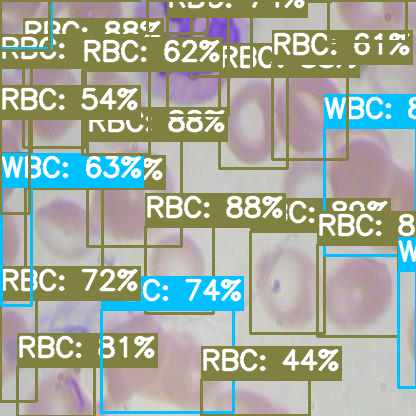

In [ ]:
from deepsparse import Pipeline
from deepsparse.yolo.utils import annotate_image
from PIL import Image
import numpy as np

image_path = "BCCD-4/valid/images/BloodImage_00273_jpg.rf.3afa11585956bb72377944044c2b2d7f.jpg"
model_stub = "yolov5_runs/train/exp46/DeepSparse_Deployment/last.onnx"
class_names = {"0":"Platelets","1":"RBC","2":"WBC"}
yolo_pipeline = Pipeline.create(
    task="yolo",
    model_path=model_stub,
    class_names=class_names
)
pipeline_outputs = yolo_pipeline(images=image_path, iou_thres=0.6, conf_thres=0.001)
image = Image.open(image_path)
sparse_annotation = annotate_image(image=image, prediction=pipeline_outputs)
PIL_image = Image.fromarray(np.uint8(sparse_annotation)).convert('RGB')
PIL_image

## Sparse Transfer Learning With YOLOv5


You can also use a YOLOv5 model that has already been sparsified to leverage the previous pruning process instead of starting from scratch.

SparseZoo provides numerous pre-sparsified models to choose from. In the following example, we choose a YOLOv5 model that has been pruned to 85% sparsity. This means that the model will start from the pruned 85% weights trained on VOC and train further on the red blood cells dataset, maintaining the sparsity and then quantizing the model.

In [ ]:
!sparseml.yolov5.train \
  --data BCCD-4/data.yaml \
  --weights zoo:cv/detection/yolov5-s/pytorch/ultralytics/voc/pruned85_quant-none

train: weights=zoo:cv/detection/yolov5-s/pytorch/ultralytics/voc/pruned85_quant-none, cfg=, teacher_weights=, data=BCCD-4/data.yaml, data_path=, hyp=../env_mgoin/lib/python3.10/site-packages/yolov5/data/hyps/hyp.scratch-low.yaml, epochs=300, batch_size=16, gradient_accum_steps=-1, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=/home/ubuntu/mwiti/yolov5_runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, recipe=None, recipe_args=None, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: skipping check (not a git repository), for updates see https://github.com/ultralytics/yolov5
YOLOv5 🚀 2023-4-21 Python-3.10.9 torch-1.12.0+cu116 CUDA:0 (NVIDIA RTX A4000, 16109MiB

## Export Model to ONNX

In [ ]:
!sparseml.yolov5.export_onnx \
    --weights yolov5_runs/train/exp48/weights/last.pt \
    --dynamic

export: data=../env_mgoin/lib/python3.10/site-packages/yolov5/data/coco128.yaml, data_path=, weights=['yolov5_runs/train/exp48/weights/last.pt'], imgsz=[640, 640], batch_size=1, device=cpu, half=False, inplace=False, keras=False, optimize=False, int8=False, dynamic=True, simplify=False, opset=12, verbose=False, workspace=4, nms=False, agnostic_nms=False, topk_per_class=100, topk_all=100, iou_thres=0.45, conf_thres=0.25, export_samples=0, include=['onnx'], one_shot=None
export: data=../env_mgoin/lib/python3.10/site-packages/yolov5/data/coco128.yaml, data_path=, weights=['yolov5_runs/train/exp48/weights/last.pt'], imgsz=[640, 640], batch_size=1, device=cpu, half=False, inplace=False, keras=False, optimize=False, int8=False, dynamic=True, simplify=False, opset=12, verbose=False, workspace=4, nms=False, agnostic_nms=False, topk_per_class=100, topk_all=100, iou_thres=0.45, conf_thres=0.25, export_samples=0, include=['onnx'], one_shot=None
YOLOv5 🚀 2023-4-21 Python-3.10.9 torch-1.12.0+cu116 

## Benchmark the model using DeepSparse

In [ ]:
!deepsparse.benchmark \
   yolov5_runs/train/exp48/DeepSparse_Deployment/last.onnx  \
    --scenario sync

2023-08-01 17:58:44 deepsparse.benchmark.benchmark_model INFO     Thread pinning to cores enabled
DeepSparse, Copyright 2021-present / Neuralmagic, Inc. version: 1.5.2 COMMUNITY | (93c38382) (release) (optimized) (system=avx2, binary=avx2)
2023-08-01 17:58:45 deepsparse.benchmark.benchmark_model INFO     deepsparse.engine.Engine:
	onnx_file_path: yolov5_runs/train/exp48/DeepSparse_Deployment/last.onnx
	batch_size: 1
	num_cores: 23
	num_streams: 1
	scheduler: Scheduler.default
	fraction_of_supported_ops: 1.0
	cpu_avx_type: avx2
	cpu_vnni: False
2023-08-01 17:58:45 deepsparse.utils.onnx INFO     Generating input 'images', type = uint8, shape = [1, 3, 640, 640]
2023-08-01 17:58:45 deepsparse.benchmark.benchmark_model INFO     Starting 'singlestream' performance measurements for 10 seconds
Original Model Path: yolov5_runs/train/exp48/DeepSparse_Deployment/last.onnx
Batch Size: 1
Scenario: sync
Throughput (items/sec): 92.6455
Latency Mean (ms/batch): 10.7776
Latency Median (ms/batch): 10.80

## Deploy YOLOv5 Object Detection
The next step is to perform detection on the blood cells dataset using the trained YOLOv5 model with DeepSparse. DeepSparse expects models in the ONNX format, allowing you to deploy the model on CPUs with the performance of a CPU.  

Deploy the model using DeepSparse by proving the exported ONNX file as the model. You also need to provide:

- The path to a test image from the test folder
- Mapping of the class names
- The desired thresholds


In [ ]:
from deepsparse import Pipeline
image_path = "BCCD-4/valid/images/BloodImage_00335_jpg.rf.a6e7e0bdb343a8c39c49bae71c2e864a.jpg"
model_stub = "yolov5_runs/train/exp43/DeepSparse_Deployment/last.onnx"
class_names = {"0":"Platelets","1":"RBC","2":"WBC"}
yolo_pipeline = Pipeline.create(
    task="yolo",
    model_path=model_stub,
    class_names=class_names
)
pipeline_outputs = yolo_pipeline(images=image_path, iou_thres=0.6, conf_thres=0.001)

Use the YOLO utils file to annotate the sample image and display it using Pillow:

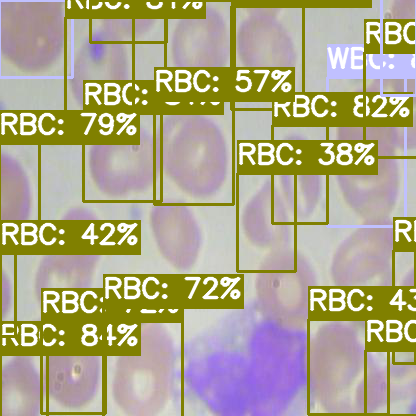

In [ ]:
from deepsparse.yolo.utils import annotate_image
from PIL import Image
import numpy as np
image = Image.open(image_path)
sparse_annotation = annotate_image(image=image, prediction=pipeline_outputs)
PIL_image = Image.fromarray(np.uint8(sparse_annotation)).convert('RGB')
PIL_image

## Where to go from here
This guide has shown how to fine-tune a YOLOv5 model on a custom dataset and get a sparse model. You have seen how easy it is to use SparseML to train sparse object detection models without affecting accuracy.

You can try SparseML with object detection models such as [YOLACT](https://neuralmagic.com/blog/real-time-instance-segmentation-with-sparse-yolact-on-a-laptop/) and another custom dataset. In case of any problems, submit an issue on [GitHub](https://github.com/neuralmagic/sparseml) or ask a question on our [community](https://join.slack.com/t/discuss-neuralmagic/shared_invite/zt-q1a1cnvo-YBoICSIw3L1dmQpjBeDurQ).

